In [1]:
from math import sqrt
from scipy import stats
from pydataset import data
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from env import host, user, password
from acquire import get_telco_data, get_telco_df
from prepare import prep_telco, split_data, convert_cats

## Data Acquistion
 -Will be using functions from our acquire.py to build our pandas dataframes from SQL and form local CSV files

In [2]:
telco_df = get_telco_df()  ##displaying head of the dataframe just built using our get_telco_df
                           ## function which connects to SQL and reads the table into a 
                           ## pandas dataframe and creates a local CSV file.

In [3]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [4]:
def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [5]:
def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('-------------------------------------------')
    print(df.info())
    print('-------------------------------------------')
    print(col_range(df))

In [6]:
summarize_df(telco_df)

This dataframe has 7043 rows and 24 columns.
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             704

In [7]:
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [8]:
def df_value_counts(df):
    for col in df.columns:
        if df[col].dtype == object:
            print(df[col].value_counts())
            print("-----------------")

In [9]:
df_value_counts(telco_df)

8218-FFJDS    1
3524-WQDSG    1
2085-JVGAD    1
2369-UAPKZ    1
8884-ADFVN    1
             ..
2794-XIMMO    1
0817-HSUSE    1
3557-HTYWR    1
0260-ZDLGK    1
0323-XWWTN    1
Name: customer_id, Length: 7043, dtype: int64
-----------------
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------
No     3641
Yes    3402
Name: partner, dtype: int64
-----------------
No     4933
Yes    2110
Name: dependents, dtype: int64
-----------------
Yes    6361
No      682
Name: phone_service, dtype: int64
-----------------
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
-----------------
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
-----------------
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
-----------------
No                     3095
Yes                    2422
No inter

## Data Preparation

In [10]:
telco_df.total_charges = telco_df.total_charges.str.replace(' ', '0').astype(float)
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [11]:
telco_df.isnull().sum() ## now we have no null values after changing the 11 blank string values 
## in total_charges

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [12]:
cols = ['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',]

In [13]:
def graph_distributions(df):
    for col in df[cols]:
        plt.hist(df[col])
        plt.title(f'Distribution of {col}')
        plt.ylabel('Number of Customers')
        plt.xlabel(f'{col}: values')
        plt.show()

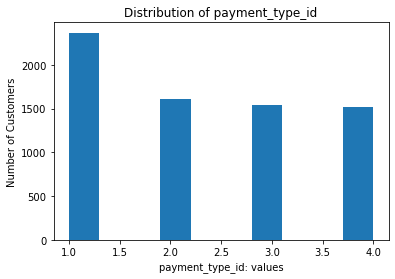

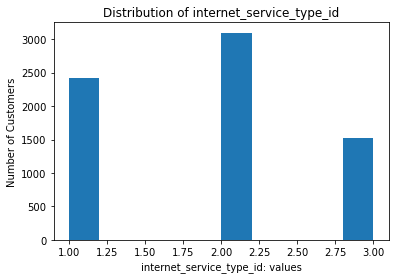

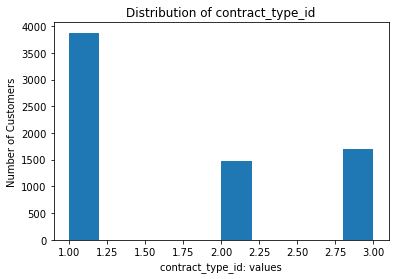

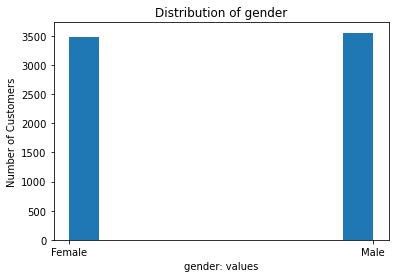

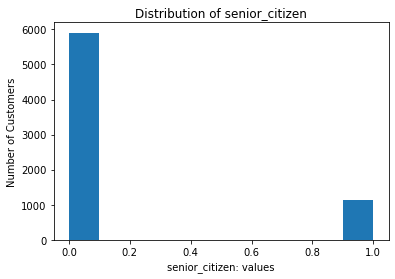

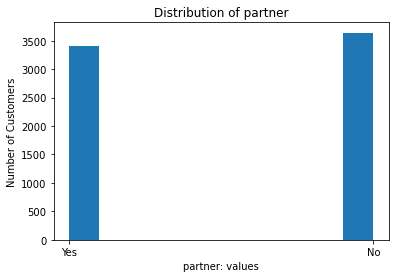

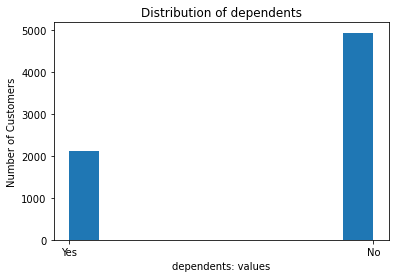

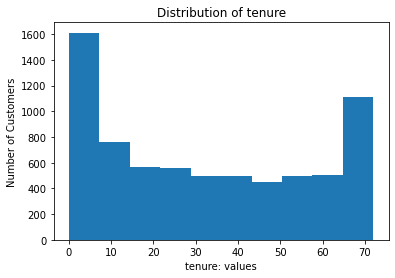

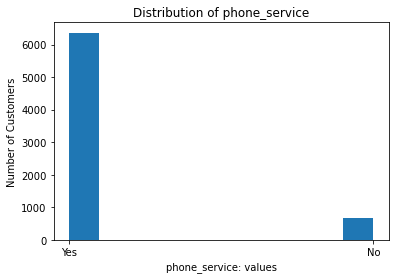

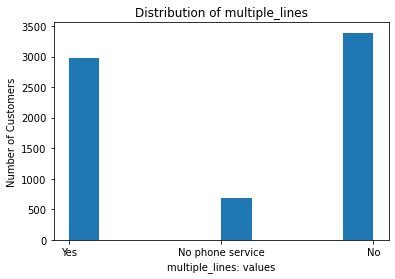

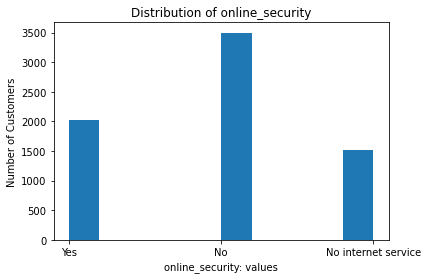

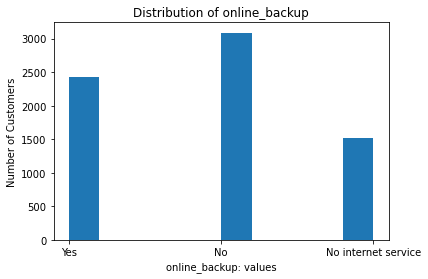

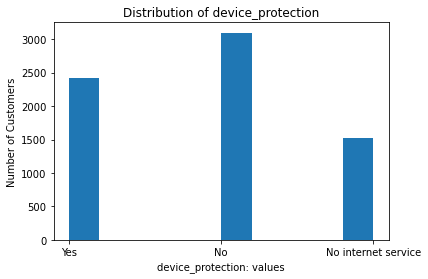

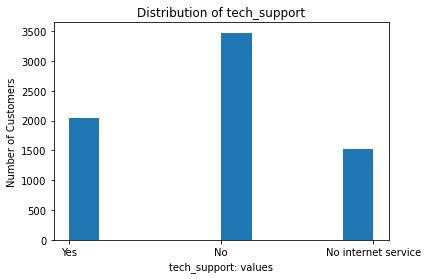

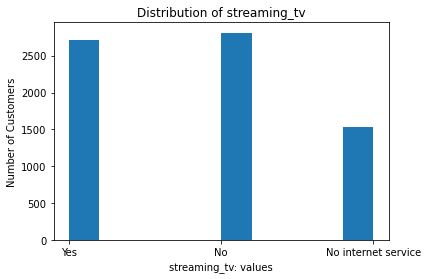

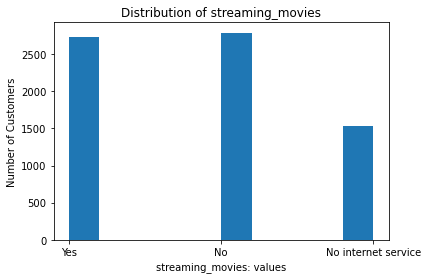

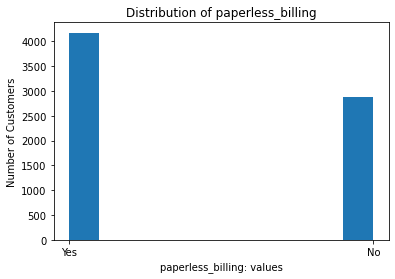

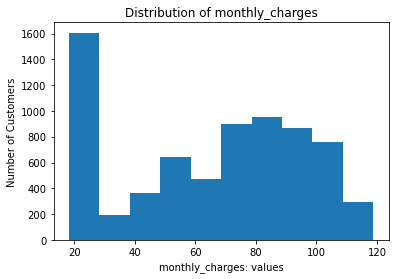

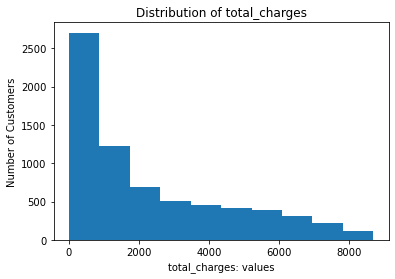

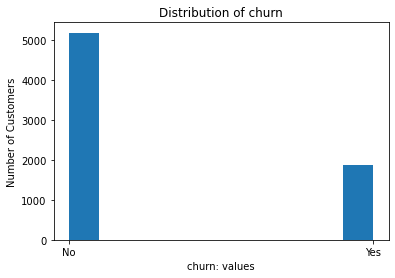

In [14]:
graph_distributions(telco_df)

In [15]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.90,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.40,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic)


In [16]:
train, validate, test = split_data(telco_df) ##using function from prepare to split data

In [17]:
train.shape, validate.shape, test.shape ##making sure shape is consistent with the normal

((3943, 24), (1691, 24), (1409, 24))

In [18]:
train.head() ##showing train df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
5642,4,3,3,1982-FEBTD,Female,0,Yes,Yes,23,Yes,...,No internet service,No internet service,No internet service,Yes,25.60,514.75,No,Two year,None,Credit card (automatic)
3338,3,2,2,8982-NHAVY,Male,0,No,No,27,Yes,...,No,Yes,Yes,Yes,100.50,2673.45,No,One year,Fiber optic,Bank transfer (automatic)
4273,1,2,1,4115-NZRKS,Female,1,No,No,7,Yes,...,No,Yes,Yes,Yes,89.15,574.35,No,Month-to-month,Fiber optic,Electronic check
2382,3,1,1,9633-DENPU,Female,0,Yes,No,47,Yes,...,No,Yes,No,Yes,58.60,2723.40,No,Month-to-month,DSL,Bank transfer (automatic)
2655,4,2,3,5693-PIPCS,Male,0,No,No,41,Yes,...,Yes,Yes,Yes,Yes,99.65,4220.35,No,Two year,Fiber optic,Credit card (automatic)


In [19]:
validate.head() ##showing validate df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
1630,2,1,1,3668-QPYBK,Male,0,No,No,2,Yes,...,No,No,No,Yes,53.85,108.15,Yes,Month-to-month,DSL,Mailed check
5181,1,2,1,8380-PEFPE,Male,0,No,Yes,1,Yes,...,No,No,No,Yes,71.65,71.65,Yes,Month-to-month,Fiber optic,Electronic check
4239,3,2,1,3956-CJUST,Female,1,No,No,23,Yes,...,No,No,No,Yes,75.40,1643.55,No,Month-to-month,Fiber optic,Bank transfer (automatic)
5814,2,3,3,4652-ODEVH,Male,0,Yes,Yes,45,Yes,...,No internet service,No internet service,No internet service,No,24.45,1088.25,No,Two year,None,Mailed check
1438,3,1,1,2100-BDNSN,Female,0,Yes,No,5,Yes,...,Yes,Yes,No,No,67.95,350.30,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [20]:
test.head() ## show test df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2789,3,2,3,8670-ERCJH,Male,0,No,No,72,Yes,...,Yes,Yes,Yes,No,113.40,8164.10,No,Two year,Fiber optic,Bank transfer (automatic)
1233,3,1,1,0356-ERHVT,Male,0,Yes,No,11,Yes,...,No,No,No,Yes,45.90,521.90,No,Month-to-month,DSL,Bank transfer (automatic)
6784,2,3,1,4786-UKSNZ,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,No,20.20,20.20,Yes,Month-to-month,None,Mailed check
3177,1,2,2,5945-AZYHT,Male,0,Yes,No,71,Yes,...,No,Yes,Yes,Yes,109.60,7854.15,No,One year,Fiber optic,Electronic check
1740,2,1,1,4432-ADRLB,Male,0,No,No,2,Yes,...,No,No,No,No,44.65,74.90,Yes,Month-to-month,DSL,Mailed check


## Explore & Hypothesis

In [21]:
cols2 = ['payment_type_id', ## making new column list to display boxplots to help with
 'gender',                  ## forming statistcal analysis questions
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',]

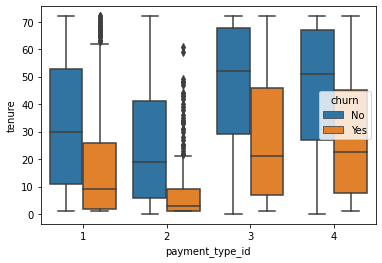

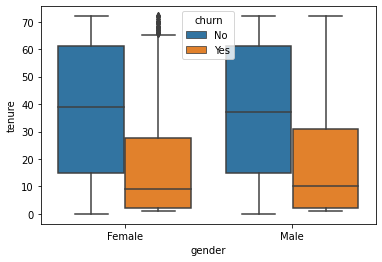

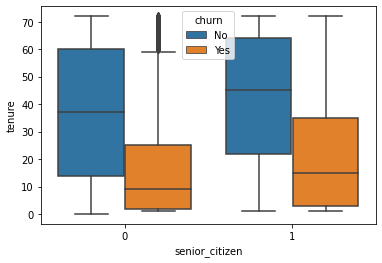

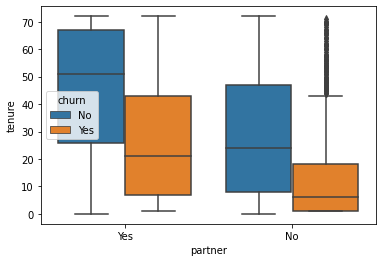

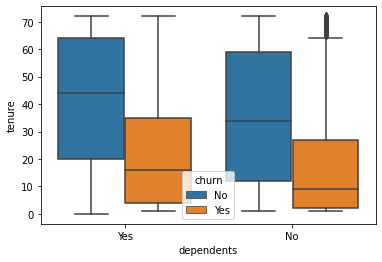

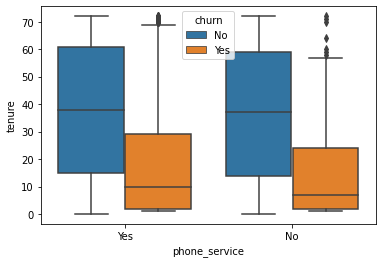

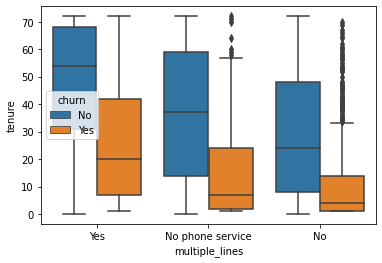

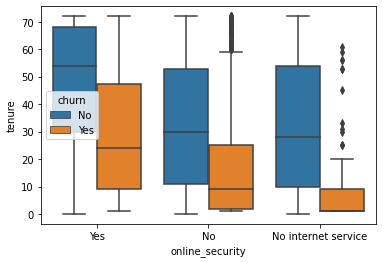

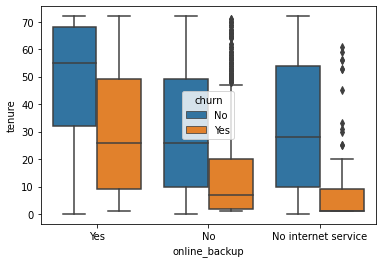

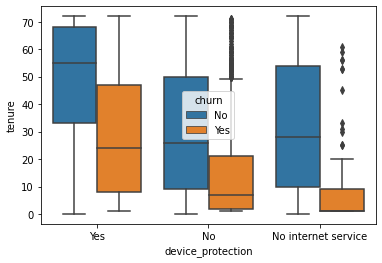

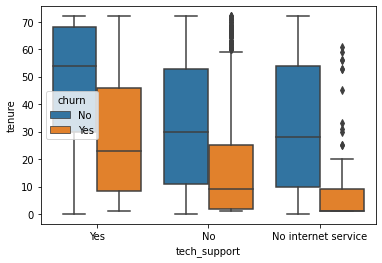

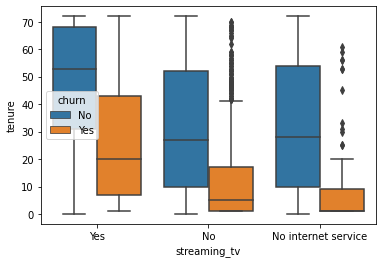

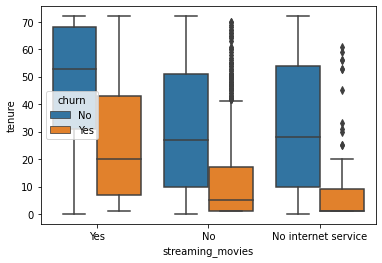

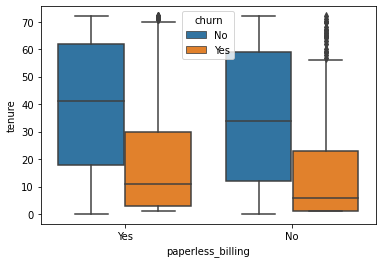

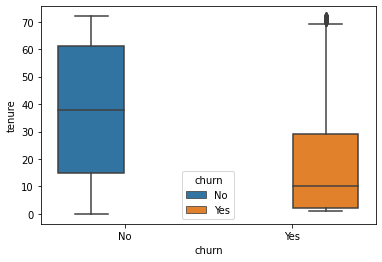

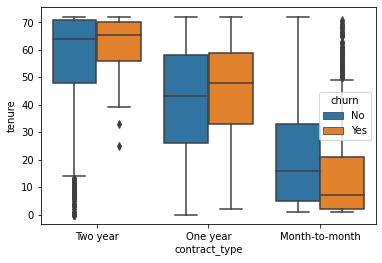

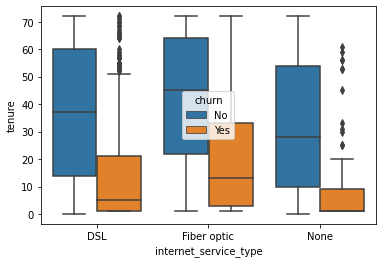

In [22]:
for col in cols2:  ### looking at box plots of tenure vs all the columns with churn
                ### as a hue to determine what questions I would like to ask for my 
        ### statistical analysis
    sns.boxplot(data = telco_df, x= col, y='tenure', hue = 'churn') 
    plt.show()

### Question 1: Is there a relationship between customers with paperless billing and whether or not they churned

In [23]:
alpha = 0.5

##### $H_0$: There is no relationship between paperless billing and whether or not a customer has churned

##### $H_a$: There is a relationship between paperless billing customers and whether or not they have churned

In [24]:
telco_num = convert_cats(telco_df) ##converting dataframe to numerical dataframe for computer format
telco_num.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,9,0,0,1,1,65,1,...,2,2,2,1,90.45,5957.90,0,2,0,3
1,4,1,3,10,1,0,0,0,54,0,...,2,2,0,0,45.20,2460.55,0,2,0,1
2,3,1,3,14,0,0,0,0,56,0,...,2,0,0,0,45.05,2560.10,0,2,0,0
3,4,1,3,34,1,0,1,1,20,0,...,2,0,0,1,39.40,825.40,0,2,0,1
4,3,1,3,45,1,0,1,0,72,1,...,2,2,2,1,85.15,6316.20,0,2,0,0


In [26]:
observed = pd.crosstab(telco_num.paperless_billing, telco_num.churn)

## ^making a crosstab of the observed values for the chi^2 test. (paperless_billing and churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

## ^ performing the test on observed and outputting results
print('Observed\n')
print(observed)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

churn                 0     1
paperless_billing            
0                  2403   469
1                  2771  1400
---
Expected

[[2109.85773108  762.14226892]
 [3064.14226892 1106.85773108]]
---

chi^2 = 258.2776
p     = 0.0000


#### Given our p value is less than our alpha (0.5) and is nearly approaching 0 we can reject our null hypothesis and same there is a significant relationship between paperless billing and whether or not a customer has churned

### Question 2: Is there a relationship between if a customer has multiple lines and whether or not they have churned

In [27]:
alpha = 0.5

##### $H_0$: There is no relationship between customers having multiple lines and whether or not they have churned

##### $H_a$: There is a relationship between customers having multiple lines and whether or not they have churned


In [28]:
observed = pd.crosstab(telco_num.multiple_lines, telco_num.churn)

## ^making a crosstab of the observed values for the chi^2 test. (paperless_billing and churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

## ^ performing the test on observed and outputting results
print('Observed\n')
print(observed)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

churn              0    1
multiple_lines           
0               2541  849
1                512  170
2               2121  850
---
Expected

[[2490.39613801  899.60386199]
 [ 501.01774812  180.98225188]
 [2182.58611387  788.41388613]]
---

chi^2 = 11.3304
p     = 0.0035


#### Given our p value is less than our alpha (0.5) and is 0.0035 we can reject our null hypothesis and same there is a significant relationship between the multiple line customer data and whether or not they have churned

In [29]:
X_train, y_train = train[cols], train.churn
X_validate, y_validate = validate[cols], validate.churn
X_test, y_test = test[cols], test.churn